In [7]:
import lib
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
import seaborn as sns

In [46]:
labelizer = lib.Labelizer()

In [313]:
bin_size = 1

train, test = lib.load_base_datasets()
train = lib.rgb2lab_dataset(train)
train = lib.split_l_and_ab_dataset(train)
train = lib.quantize_dataset(train, bin_size=bin_size)
# train = train.map(lambda l, ab: (l, tf.histogram_fixed_width_bins(ab, value_range=[-130.,130.])))
# train_count = train.map(lambda l, ab: (l, tf.histogram_fixed_width_bins(ab, value_range=[-130.,130.])))
train = train.map(lambda l, ab: (l, ab[:,:,:,1] + 128 + 256*(ab[:,:,:,0] + 128)))
#train = labelizer.label_dataset(train)
# train = train.cache().prefetch(buffer_size=1)

Found 33062 files.
Using 26450 files for training.
Using 6612 files for validation.


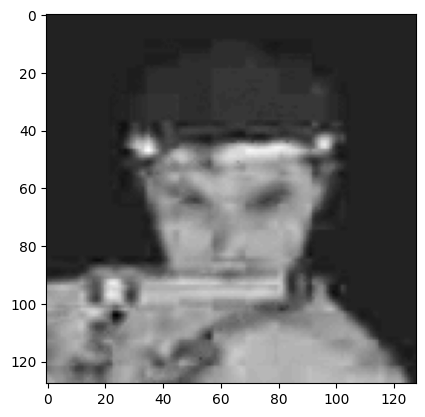

In [285]:
plt.imshow(next(iter(train))[1][0,...], cmap="gray")

In [314]:
shapedude = 256**2


hist = train.map(
    lambda _, label: tf.unique_with_counts(tf.experimental.numpy.flatten(label))
).map(lambda elem: 
      tf.sparse.reorder(
          tf.sparse.SparseTensor(
              indices=tf.reshape(tf.cast(elem[0], dtype=tf.dtypes.int64),
                                    (len(elem[0]), 1)),
                                    values=int(elem[-1]), 
                                 dense_shape=[shapedude]))
      ).reduce(tf.sparse.SparseTensor([[1]], [0], [shapedude]), lambda s, elem: tf.sparse.reorder(tf.sparse.add(s, elem)))

In [291]:
train_count = train.map(
    lambda _, label: tf.unique_with_counts(tf.experimental.numpy.flatten(label))
)
np.max(next(iter(train_count))[0].numpy())

np.float32(56640.0)

In [292]:
hist

SparseTensor(indices=tf.Tensor(
[[    1]
 [ 5345]
 [ 5346]
 ...
 [57159]
 [57160]
 [57161]], shape=(21683, 1), dtype=int64), values=tf.Tensor([   0    3  127 ...  150 3513   18], shape=(21683,), dtype=int32), dense_shape=tf.Tensor([65536], shape=(1,), dtype=int64))

In [252]:
57201%256 - 168

-55

In [315]:
hist_d = tf.sparse.to_dense(tf.sparse.reorder(hist)).numpy()

In [316]:
hist_s = np.reshape(hist_d, (256,256))

/tmp/ipykernel_96232/1131923059.py:1: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(-np.log(hist_s/np.sum(hist_s)), mask=hist_s==0, cmap="Spectral", square=True,xticklabels=False, yticklabels=False,cbar=False)


<Axes: >

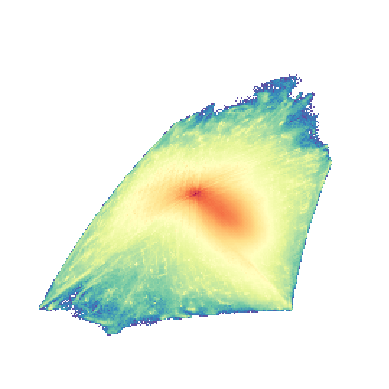

In [330]:
sns.heatmap(-np.log(hist_s/np.sum(hist_s)), mask=hist_s==0, cmap="Spectral", square=True,xticklabels=False, yticklabels=False,cbar=False)

In [ ]:
im = np.zeros(shape=(256, 256))
for (a,b), l in labelizer.ab_to_label.items():
    print(a)
    a = int(a)
    print(a)
    b = int(b)
    half_bin = bin_size//2
    im[a+(128-half_bin):a+(128+half_bin), b+(128-half_bin):b+(128+half_bin)] += np.log(labelizer.label_counts[l])

-5.0
-5
5.0
5
15.0
15
15.0
15
35.0
35
25.0
25
35.0
35
25.0
25
-5.0
-5
5.0
5
-15.0
-15
-25.0
-25
-15.0
-15
-25.0
-25
5.0
5
-5.0
-5
25.0
25
15.0
15
45.0
45
55.0
55
55.0
55
65.0
65
75.0
75
65.0
65
55.0
55
45.0
45
35.0
35
65.0
65
-35.0
-35
-15.0
-15
-35.0
-35
-45.0
-45
-35.0
-35
45.0
45
-5.0
-5
-25.0
-25
-45.0
-45
85.0
85
75.0
75
75.0
75
85.0
85
85.0
85
75.0
75
75.0
75
-55.0
-55
-55.0
-55
-95.0
-95
-85.0
-85
-95.0
-95
-75.0
-75
-85.0
-85
-75.0
-75
-65.0
-65
-65.0
-65
25.0
25
15.0
15
5.0
5
25.0
25
25.0
25
-45.0
-45
35.0
35
-55.0
-55
15.0
15
35.0
35
-15.0
-15
-5.0
-5
5.0
5
-65.0
-65
45.0
45
5.0
5
65.0
65
65.0
65
55.0
55
55.0
55
45.0
45
-5.0
-5
-15.0
-15
-5.0
-5
-45.0
-45
-35.0
-35
-55.0
-55
-25.0
-25
35.0
35
35.0
35
95.0
95
15.0
15
5.0
5
-25.0
-25
95.0
95
45.0
45
15.0
15
25.0
25
-15.0
-15
-25.0
-25
-35.0
-35
-75.0
-75
-75.0
-75
85.0
85
-105.0
-105
55.0
55
55.0
55
5.0
5
-65.0
-65
-45.0
-45
-55.0
-55
-45.0
-45
-65.0
-65
-15.0
-15
15.0
15
-25.0
-25
-35.0
-35
-15.0
-15
-85.0
-85
-85.0
-85
35.0
3

In [ ]:
sum(labelizer.label_counts.values())
sum(labelizer.label_counts.values())/(26450*128*128)

0.015625

<Axes: >

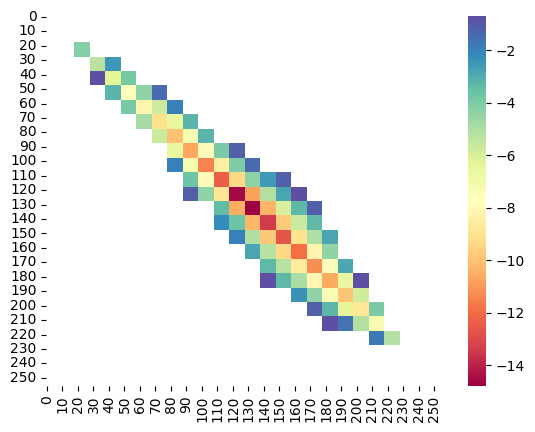

In [ ]:
sns.heatmap(-im, mask=im==0, cmap="Spectral")

In [ ]:
# train.save(compression="GZIP", path="save-dataset-labeled/")

In [ ]:
test = lib.rgb2lab_dataset(test)
test = lib.split_l_and_ab_dataset(test)
test = lib.quantize_dataset(test)
test = labelizer.label_dataset(test)

labelizer.last_label


117

In [ ]:
abs = np.array([[labelizer.ab_pixel_to_label(np.array([(a//bin_size)*bin_size + bin_size//2, (b//bin_size)*bin_size + 5]), add=False) for b in range(-128, 128)] for a in range(-128,128)])

In [ ]:
rainbow_abs = np.array([[skimage.color.lab2rgb(np.array([[[50., float((a//bin_size)*bin_size + bin_size//2), float((b//bin_size)*bin_size + bin_size//2)]]]))[0,0] if labelizer.ab_pixel_to_label(np.array([(a//10)*10 + 5, (b//10)*10 + 5]), add=False) != -1 else np.array([0, 0, 0]) for b in range(-128,128)] for a in range(-128,128)])

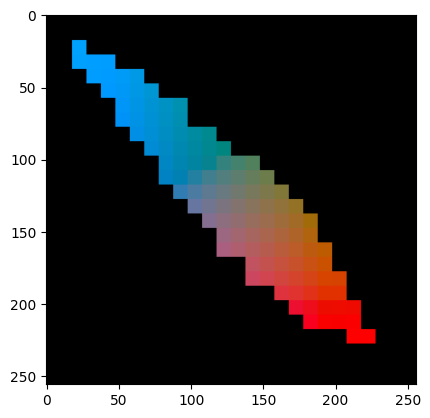

In [ ]:
plt.imshow(rainbow_abs)

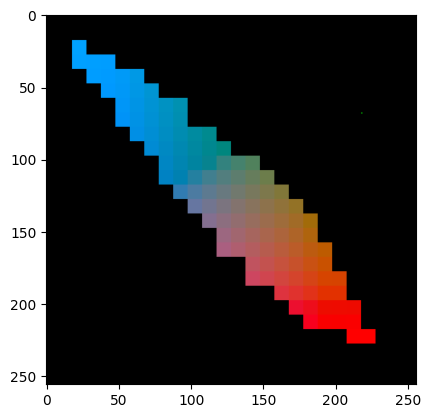

In [ ]:
# a = 70, b=-110
# a_arno = 90
# b_arno= -80
a_arno = -60
b_arno = 90
rainbow_abs[a_arno+128, b_arno+128] = skimage.color.lab2rgb([[[50., float(a_arno), float(b_arno)]]])[0,0]
plt.imshow(rainbow_abs)

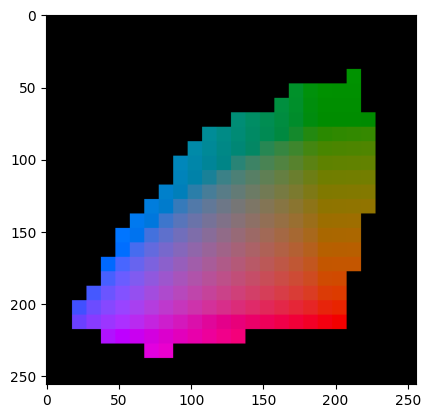

In [ ]:
arno_dict = {(-10.0, -20.0): 0, (-0.0, -30.0): 1, (-0.0, -20.0): 2, (10.0, -30.0): 3, (-10.0, -30.0): 4, (-20.0, -10.0): 5, (-10.0, -10.0): 6, (-0.0, -10.0): 7, (0.0, -0.0): 8, (10.0, -0.0): 9, (10.0, -10.0): 10, (10.0, 10.0): 11, (20.0, 10.0): 12, (10.0, 20.0): 13, (-20.0, -20.0): 14, (20.0, 20.0): 15, (20.0, 0.0): 16, (30.0, 20.0): 17, (30.0, 10.0): 18, (30.0, 30.0): 19, (20.0, 30.0): 20, (30.0, 40.0): 21, (40.0, 30.0): 22, (10.0, 30.0): 23, (40.0, 40.0): 24, (-20.0, -30.0): 25, (20.0, 40.0): 26, (0.0, 10.0): 27, (-10.0, -0.0): 28, (0.0, 30.0): 29, (30.0, 50.0): 30, (40.0, 50.0): 31, (0.0, 20.0): 32, (10.0, 40.0): 33, (-10.0, 10.0): 34, (10.0, -20.0): 35, (-10.0, 20.0): 36, (-10.0, 30.0): 37, (10.0, -40.0): 38, (10.0, -50.0): 39, (20.0, -50.0): 40, (0.0, -40.0): 41, (0.0, -50.0): 42, (-20.0, 0.0): 43, (10.0, -60.0): 44, (-10.0, -40.0): 45, (20.0, -10.0): 46, (20.0, -20.0): 47, (30.0, -10.0): 48, (20.0, 50.0): 49, (0.0, 40.0): 50, (10.0, 50.0): 51, (0.0, 50.0): 52, (-10.0, 50.0): 53, (-10.0, 40.0): 54, (0.0, 60.0): 55, (-10.0, 60.0): 56, (40.0, 20.0): 57, (50.0, 20.0): 58, (50.0, 30.0): 59, (40.0, 10.0): 60, (50.0, 40.0): 61, (60.0, 40.0): 62, (20.0, -30.0): 63, (30.0, 0.0): 64, (60.0, 30.0): 65, (60.0, 50.0): 66, (70.0, 50.0): 67, (70.0, 40.0): 68, (70.0, 60.0): 69, (-20.0, 10.0): 70, (-30.0, 10.0): 71, (-20.0, 20.0): 72, (-30.0, -0.0): 73, (-40.0, 20.0): 74, (-30.0, -10.0): 75, (-20.0, 30.0): 76, (-30.0, 50.0): 77, (-30.0, 60.0): 78, (-40.0, 60.0): 79, (-30.0, 40.0): 80, (-40.0, 70.0): 81, (-20.0, 40.0): 82, (-50.0, 70.0): 83, (-40.0, 50.0): 84, (-30.0, 70.0): 85, (-50.0, 80.0): 86, (-40.0, 80.0): 87, (-20.0, 50.0): 88, (-20.0, 60.0): 89, (-30.0, 30.0): 90, (10.0, 60.0): 91, (20.0, 60.0): 92, (-30.0, -20.0): 93, (-40.0, 10.0): 94, (-40.0, 30.0): 95, (-30.0, 20.0): 96, (-40.0, 0.0): 97, (-40.0, -10.0): 98, (-40.0, 40.0): 99, (60.0, 20.0): 100, (50.0, 10.0): 101, (30.0, -20.0): 102, (40.0, -10.0): 103, (30.0, -30.0): 104, (20.0, -40.0): 105, (30.0, -40.0): 106, (40.0, 0.0): 107, (50.0, 50.0): 108, (-20.0, 70.0): 109, (-30.0, 80.0): 110, (-10.0, 70.0): 111, (60.0, 10.0): 112, (70.0, 10.0): 113, (70.0, 20.0): 114, (20.0, -60.0): 115, (30.0, -50.0): 116, (30.0, 60.0): 117, (10.0, 70.0): 118, (40.0, -50.0): 119, (40.0, -40.0): 120, (40.0, -20.0): 121, (40.0, -30.0): 122, (50.0, -0.0): 123, (50.0, -10.0): 124, (40.0, -60.0): 125, (50.0, -70.0): 126, (50.0, -80.0): 127, (30.0, -60.0): 128, (70.0, 30.0): 129, (40.0, -70.0): 130, (60.0, 60.0): 131, (50.0, -40.0): 132, (50.0, -20.0): 133, (50.0, -30.0): 134, (60.0, -10.0): 135, (60.0, 0.0): 136, (70.0, 0.0): 137, (40.0, 60.0): 138, (50.0, -50.0): 139, (60.0, -50.0): 140, (60.0, -60.0): 141, (50.0, -60.0): 142, (60.0, -70.0): 143, (80.0, 40.0): 144, (-50.0, 20.0): 145, (0.0, 70.0): 146, (20.0, 70.0): 147, (-10.0, -50.0): 148, (-20.0, -40.0): 149, (-30.0, -30.0): 150, (30.0, -70.0): 151, (-10.0, 90.0): 152, (-0.0, 90.0): 153, (-10.0, 80.0): 154, (-0.0, 80.0): 155, (-20.0, 90.0): 156, (-20.0, 80.0): 157, (30.0, 70.0): 158, (80.0, 50.0): 159, (80.0, 60.0): 160, (40.0, 70.0): 161, (50.0, 70.0): 162, (50.0, 60.0): 163, (60.0, 70.0): 164, (-50.0, 30.0): 165, (20.0, -70.0): 166, (-50.0, 40.0): 167, (70.0, -10.0): 168, (60.0, -20.0): 169, (80.0, 70.0): 170, (-50.0, 50.0): 171, (60.0, -40.0): 172, (70.0, -40.0): 173, (70.0, -50.0): 174, (60.0, -30.0): 175, (80.0, -50.0): 176, (70.0, -30.0): 177, (-50.0, 0.0): 178, (30.0, -80.0): 179, (40.0, -80.0): 180, (50.0, -90.0): 181, (0.0, -60.0): 182, (40.0, -90.0): 183, (10.0, -70.0): 184, (-30.0, 90.0): 185, (80.0, 10.0): 186, (80.0, 20.0): 187, (80.0, 30.0): 188, (70.0, -20.0): 189, (80.0, 0.0): 190, (80.0, -10.0): 191, (-60.0, 50.0): 192, (-50.0, 60.0): 193, (-60.0, 60.0): 194, (-60.0, 70.0): 195, (10.0, 80.0): 196, (-40.0, -20.0): 197, (80.0, -20.0): 198, (-50.0, 10.0): 199, (20.0, 80.0): 200, (30.0, 80.0): 201, (40.0, 80.0): 202, (60.0, -80.0): 203, (60.0, -90.0): 204, (70.0, -90.0): 205, (70.0, -100.0): 206, (60.0, -100.0): 207, (80.0, -40.0): 208, (80.0, -30.0): 209, (90.0, -50.0): 210, (90.0, -40.0): 211, (70.0, 70.0): 212, (70.0, -60.0): 213, (80.0, -60.0): 214, (-60.0, 40.0): 215, (-60.0, 30.0): 216, (80.0, -100.0): 217, (70.0, -80.0): 218, (80.0, -90.0): 219, (70.0, -70.0): 220, (80.0, -70.0): 221, (80.0, -80.0): 222, (90.0, -60.0): 223, (-40.0, 90.0): 224, (20.0, -80.0): 225, (90.0, -90.0): 226, (90.0, -70.0): 227, (-40.0, -30.0): 228, (-50.0, -10.0): 229, (-50.0, -20.0): 230, (-60.0, 20.0): 231, (-60.0, 10.0): 232, (100.0, -60.0): 233, (100.0, -50.0): 234, (-70.0, 60.0): 235, (-70.0, 70.0): 236, (-70.0, 50.0): 237, (90.0, -30.0): 238, (-60.0, 0.0): 239, (90.0, -20.0): 240, (90.0, -10.0): 241, (90.0, -0.0): 242, (-60.0, 80.0): 243, (80.0, -110.0): 244, (-80.0, 70.0): 245, (-80.0, 80.0): 246, (-90.0, 80.0): 247, (-70.0, 40.0): 248, (-30.0, -40.0): 249, (-80.0, 60.0): 250, (-80.0, 50.0): 251, (-70.0, 30.0): 252, (-80.0, 40.0): 253, (-50.0, 90.0): 254, (-70.0, 80.0): 255, (-60.0, 90.0): 256, (70.0, -110.0): 257, (90.0, -80.0): 258}
rainbow_arno = np.array([[skimage.color.lab2rgb(np.array([[[50., (float(a)//10)*10, (float(b)//10)*10]]]))[0,0] if ((float(a)//10)*10, (float(b)//10)*10) in arno_dict.keys() else np.array([0, 0, 0]) for b in range(-128,128)] for a in range(-128,128)])
plt.imshow(rainbow_arno)